# 0. Импорт библиотек

In [1]:
from CoolRespProject.modules_parser import cr_defaults as crd  # Константы парсера
from CoolRespProject.modules_parser import cr_swiss    as crs  # Хранилище побочных функций
from CoolRespProject.modules_parser import cr_reader   as crr  # Взаимодействие с Excel
from CoolRespProject.modules_parser import cr_parser   as crp  # Регулярный парсер
from CoolRespProject.modules_parser import cr_writter  as crw  # Форматная запись в Excel
import os
import re

In [2]:
# !pip freeze > jupiter-requirements.txt

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', 905)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
jup_conds = ['all',                # Показывать все вызовы
             'last',               # Показывать последнюю общность вызовов
             'last_expr',          # Показывать самый последний вызов
             'none',               # Ничего не показывать
             'last_expr_or_assign' # Показывать последний вызов или присваивание
            ]

InteractiveShell.ast_node_interactivity = jup_conds[0]

In [5]:
base_dir = os.getcwd()
path_load = os.path.join(base_dir, 'Tests', 'Datasets')  # Путь загрузки обрабатываемых файлов
path_save = os.path.join(base_dir, 'Tests', 'Results')   # Путь сохранения итогов обработки
path_json = os.path.join(base_dir, 'Tests', 'Jsons')     # Путь сохранения json файлов
path_best = os.path.join(base_dir, 'Tests', 'JSBest')    # Где хранятся проверенные вручную json файлы

# 1. Представление данных на каждой стадии

In [6]:
book = crr.read_book(os.path.join(base_dir, 'Tests', 'Datasets', 'PE-81b_1_semestr_2021-2022.xlsx'))
book

In [7]:
sheets = crr.see_sheets(book)
sheets

['ПЕ-81б ']

In [8]:
sheet = crr.take_sheet(book, sheets[0])
sheet

In [9]:
sheet_info  = crr.group_choice(sheet)
sheet_info

{'period': ['21.09.21', '31.12.21'],
 'year': 2021,
 'groups_info': ['ПЕ-81б'],
 'range': (7, 32)}

In [10]:
period    = sheet_info['period']  # Период расписания
year      = sheet_info['year']  # Год
groups    = sheet_info['groups_info']  # Список групп на листе
start_end = sheet_info['range']  # Диапазон расписания
group = groups[0]

bd_process = crr.prepare(sheet, group, start_end)
bd_process.head()

,day,num,rec,cabs
1,ПН,2,День самоподготовки,nan
3,ВТ,1,"Функционирование телекоммуникационных сетей; 21.09.21г. -теория, с 28.09.21г по 07.12.21г. практика : доцент БукринаЕ.В.","VIII, 421 УК№3, ."
4,ВТ,2,Функционирование телекоммуникационных сетей; с 21.09.21г.по 07.12.21г. лаб.раб. 2 п/гр: доцент БукринаЕ.В.;,"421 УК№3, ."
5,ВТ,3,Сети и телекоммуникации; с 21.09.21г. по 07.12.21г. лаб.раб.-2 п/гр: преподаватель Плеханов С.М.,"215 УК№3, ."
7,СР,1,"Сети и телекоммуникации; 20,27.10; 03.11.21г практика: доцент БудылдинаН.В.","214 УК№3, ."


In [11]:
df = crp.parser(bd_process, period, year)
df['teacher'].replace('проф Мерзоцид Г.Ч.', 'доцент Неизвестных Н.А.', inplace=True)
df['cab'].replace('ХЗ', 'НД', inplace=True)
df.head()

,day,num,item_name,teacher,type,pdgr,date_pair,cab
0,ПН,2,День самоподготовки,доцент Неизвестных Н.А.,рейд,общ,2021-09-20,НД
1,ПН,2,День самоподготовки,доцент Неизвестных Н.А.,рейд,общ,2021-09-27,НД
2,ПН,2,День самоподготовки,доцент Неизвестных Н.А.,рейд,общ,2021-10-04,НД
3,ПН,2,День самоподготовки,доцент Неизвестных Н.А.,рейд,общ,2021-10-11,НД
4,ПН,2,День самоподготовки,доцент Неизвестных Н.А.,рейд,общ,2021-10-18,НД


In [12]:
df_items = df['item_name'].value_counts()
df_items

Сети и телекоммуникации                        66
Защита информации                              53
Функционирование телекоммуникационных сетей    52
Объектно - ориентированное программирование    42
День самоподготовки                            29
Современные Web-технологии                     22
Name: item_name, dtype: int64

In [13]:
df[df['item_name'] == 'Сети и телекоммуникации'].head(15)

,day,num,item_name,teacher,type,pdgr,date_pair,cab
39,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-09-21,215 УК№3
40,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-09-28,215 УК№3
41,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-10-05,215 УК№3
42,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-10-12,215 УК№3
43,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-10-19,215 УК№3
44,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-10-26,215 УК№3
45,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-11-02,215 УК№3
46,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-11-09,215 УК№3
47,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-11-16,215 УК№3
48,ВТ,3,Сети и телекоммуникации,преподаватель Плеханов С.М.,ЛБ,2,2021-11-23,215 УК№3


<AxesSubplot:title={'center':'Объём предметов'}>

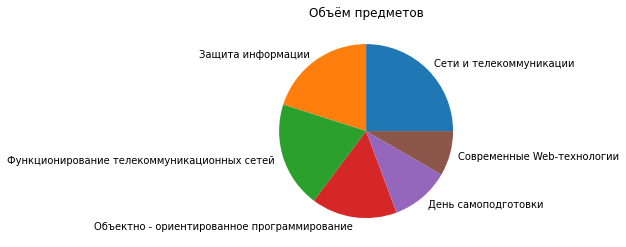

In [14]:
df_items.plot(kind = 'pie', figsize = (10, 4), title = 'Объём предметов', ylabel = '')

<AxesSubplot:title={'center':'Объём предметов'}>

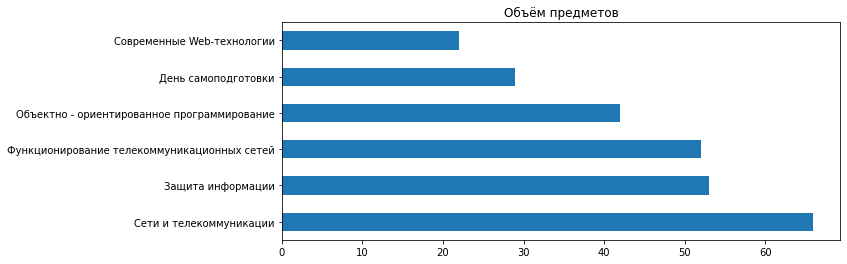

In [15]:
df_items.plot(kind = 'barh', figsize = (10, 4), title = 'Объём предметов')

In [16]:
df_to_xlsx = crw.create_resp(df, '0', '1')
df_to_xlsx

In [17]:
path = os.path.join(base_dir, 'Tests', 'Results',
                    f'{crs.create_name(df)}.xlsx')
crw.save_resp(df_to_xlsx, path)
path

'D:\\CoolResp\\Tests\\Results\\Респа для ПЕ-81б на [08.09.2021 - 30.12.2021].xlsx'

# 2. Тестирование модуля взаимодействия с исходным Excel-документом

In [16]:
help(crr)

Help on module CoolRespProject.modules_parser.cr_reader in CoolRespProject.modules_parser:

NAME
    CoolRespProject.modules_parser.cr_reader

DESCRIPTION
    Взаимодействие с исходным Excel-документом.
    Данный модуль предназначен для:
        - Считывания изначального файла расписания из .xls или .xlsx;
        - Вычленения расписания конкретной выбранной группы из считанного файла.

FUNCTIONS
    group_choice(sheet: 'Объект листа с загруженной книги') -> 'Словарь {Список групп на листе, индексный диапазон расписания}'
        Функция для выделения описательной информации о группах и границах на листе
    
    prepare(sheet: 'Выбранный лист', group: 'Выбранная группа', coord: 'Диапазон информации о расписании') -> 'Датафрейм предварительных данных'
        Функция для подготовки расписания выбранной группы к парсингу
    
    read_book(file: 'Путь к загружаемому файлу', ext: 'Расширение документа' = '') -> 'Объект книги в формате типизированного словаря'
        Функция для считыва

In [17]:
def test_reader(path, file):
    """ Функция для тестирования взаимодействия с исходными файлами расписания """
    
    # Построение пути к заданному файлу в заданной директории
    file_path = os.path.join(path, file)
    print(f'Открытие файла «{file_path}»')

    # Считывание EXCEL-таблицы
    book = crr.read_book(file_path)
    assert book!=crd.READING_BOOK, f'Не удалось открыть файл «{file}» как Excel-книгу!'
    
    # Получение списка названий листов в книге
    sheets = crr.see_sheets(book)
    assert sheets, f'Не удалось обнаружить листы в книге «{file}»!'
    print(f'Список листов в файле: «{sheets}»')

    # Проход по всем названиям листов в книге
    for sheet_name in sheets:
        # Выбор листа sheet_name
        sheet = crr.take_sheet(book, sheet_name)
        assert sheet, f'Не удалось получить доступ к листу «{sheet_name}»'
        
        # Получение информации о выбранном листе
        sheet_info = crr.group_choice(sheet)
        assert sheet_info.values()!=crd.GROUP_INFORMATION, \
                'На листе не обнаружены позиционные метки расписания! (Период расписания, группы, начальник УО)'
        print(f'{sheet_name}: {sheet_info}')
        period, year, groups, start_end = sheet_info.values()

In [18]:
# Проход по всем файлам и подпапкам в директории
for root, d, files in os.walk(path_load):
    for file in files:
        test_reader(path_load, file)
        print()

Открытие файла «E:\CoolResp\Tests\Datasets\1_KURS_2018-2019_2semestr.xls»
Список листов в файле: «['МЕ, ИТ, ОЕ81б']»
МЕ, ИТ, ОЕ81б: {'period': ['28.01.19', '01.06.19'], 'year': 2019, 'groups_info': ['МЕ-81б', 'ИТ-81б', 'ОЕ-81б'], 'range': (7, 33)}

Открытие файла «E:\CoolResp\Tests\Datasets\2_kurs_2semestr_2018-2019.xls»
Список листов в файле: «['МЕ,ОЕ 71б', 'ИТ,ВЕ-71б']»
МЕ,ОЕ 71б: {'period': ['28.01.19', '01.06.19'], 'year': 2019, 'groups_info': ['МЕ-71б', 'ОЕ-71б'], 'range': (10, 51)}
ИТ,ВЕ-71б: {'period': ['28.01.19', '01.06.19'], 'year': 2019, 'groups_info': ['ИТ-71б', 'ВЕ-71б'], 'range': (10, 48)}

Открытие файла «E:\CoolResp\Tests\Datasets\3_kurs_2018-2019_II_semestr.xls»
Список листов в файле: «['МЕ,ОЕ-61б', 'ИТ,ВЕ-61б']»
МЕ,ОЕ-61б: {'period': ['28.01.19', '01.06.19'], 'year': 2019, 'groups_info': ['МЕ-61б', 'ОЕ-61б'], 'range': (10, 39)}
ИТ,ВЕ-61б: {'period': ['28.01.19', '01.06.19'], 'year': 2019, 'groups_info': ['ИТ-61б', 'ВЕ-61б'], 'range': (10, 40)}

Открытие файла «E:\Cool

# 3. Тестирование модуля парсинга

In [19]:
help(crp)

Help on module CoolRespProject.modules_parser.cr_parser in CoolRespProject.modules_parser:

NAME
    CoolRespProject.modules_parser.cr_parser - Парсинг датафрейма с ячейками расписания конкретной группы.

FUNCTIONS
    expand_dates(dates: 'Список подстрок с датами предмета', year: 'Год (берётся из периода расписания)', day: 'День недели, соответствующий списку дат') -> 'Список объектов дат'
        Функция абсолютного разбития дат
    
    format_group(group: 'Подстрока форматируемой подгруппы') -> 'Отформатированная подгруппа'
        Функция форматирования подгруппы
    
    format_prep(lecturer: 'Форматируемая подстрока преподавателя') -> 'Отформатированная подстрока преподавателя'
        Функция форматирования записи преподавателя
    
    format_tip(tip: 'Подстрока форматируемого типа пары') -> 'Отформатированный тип пары'
        Функция форматирования типа пары
    
    parser(stuff: 'База обработки', timey: 'Период расписания', year: 'Год расписания') -> 'База парсинга'
      

In [20]:
# Конвертация базы парсинга в датафрейм
def parse_convert_to_dataframe(bd_parse):
    df = pd.DataFrame(data=bd_parse,
                      columns=['day',        # День недели
                               'num',        # Номер пары
                               'item_name',  # Название предмета
                               'teacher',    # Препод
                               'type',       # Тип пары
                               'pdgr',       # Подгруппа
                               'date_pair',  # Дата
                               'cab'         # Кабинет
                              ]).explode('date_pair').reset_index(drop=True).drop_duplicates()

    # Выделение реального периода расписания
    date_min = df['date_pair'].dropna().min().strftime('%d.%m.%Y')
    date_max = df['date_pair'].dropna().max().strftime('%d.%m.%Y')

    # Имя датафрейма
    df.name = f'Респа для {group} на [{date_min} - {date_max}]'
    
    return df

In [21]:
def test_parser(sheet, group, start_end, period, year):
    """ Функция для тестирования процесса парсинга расписания """
    
    count_act_df = count_saved_df = count_best_df = difs_all_count = difs_cab_count = 0
    
    # Создание базы с данными для предварительной обработки
    bd_process = crr.prepare(sheet, group, start_end)

    # Создание базы с запарсенными данными
    df = crp.parser(bd_process, period, year)

    # Сохранение базы парсинга в JSON
    crs.database_to_json(df, path_json)
    df.name = crs.create_name(df)

    # Путь к сохранённой базе парсинга
    path_to_act = os.path.join(path_json, f'{df.name}.json')
    # Путь к "идеальной" версии этой базы (если есть)
    path_to_best_if = os.path.join(path_best, f'{df.name}.json')
    # Если у базы парсинга есть "идеальная" версия, то сравнить их
    if os.path.exists(path_to_best_if):
        # Количество записей в запарсенном датафрейме
        count_act_df = df.shape[0]

        # Открытие запарсенного датафрейма, сохранённого в файл (на случай ошибок в сохранении)
        df1 = pd.read_json(path_to_act)
        df1['date_pair'] = pd.to_datetime(df1['date_pair']).dt.strftime('%Y-%m-%d')
        count_saved_df = df1.shape[0]

        # Открытие "идеального" датафрейма, сохранённого в файл
        df2 = pd.read_json(path_to_best_if).explode('date_pair').reset_index(drop=True)
        df2['date_pair'] = pd.to_datetime(df2['date_pair']).dt.strftime('%Y-%m-%d')
        count_best_df = df2.shape[0]

        # Сравнение датафреймов
        difs = crs.df_differences(df1, df2)
        if not difs.empty:
            difs_all_count = difs[difs['_merge'] == 'right_only'].shape[0]


        # Сравнение без учёта столбца кабинетов
        # Открытие запарсенного датафрейма, сохранённого в файл (на случай ошибок в сохранении)
        df1 = pd.read_json(path_to_act).drop(['cab'], axis=1)
        df1['date_pair'] = pd.to_datetime(df1['date_pair']).dt.strftime('%Y-%m-%d')

        # Открытие "идеального" датафрейма, сохранённого в файл
        df2 = pd.read_json(path_to_best_if).drop(['cab'], axis=1).explode('date_pair').reset_index(drop=True)
        df2['date_pair'] = pd.to_datetime(df2['date_pair']).dt.strftime('%Y-%m-%d')

        # Сравнение датафреймов
        difs = crs.df_differences(df1, df2)
        if not difs.empty:
            difs_cab_count = difs[difs['_merge'] == 'right_only'].shape[0]
    else:                    
        # файл не существует
        print(f'Лучшего результата нет ({df.name})')
    
    return count_act_df, count_saved_df, count_best_df, difs_all_count, difs_cab_count

In [22]:
count_act_df = count_saved_df = count_best_df = difs_cab_count = difs_all_count = 0
# Выбор подгрупп
g2, g3 = '0', '0'

# Проход по всем файлам и подпапкам в директории
for root, d, files in os.walk(path_load):
    for file in files:    
        # Построение пути к заданному файлу в заданной директории
        file_path = os.path.join(path_load, file)
        print(f'Открытие файла «{file_path}»')

        book = crr.read_book(file_path)
        sheets = crr.see_sheets(book)
        for sheet_name in sheets:
            sheet = crr.take_sheet(book, sheet_name)
            sheet_info = crr.group_choice(sheet)
            period, year, groups, start_end = sheet_info.values()
            
            for group in groups:
                # Создать расписание для каждой группы
                test_count = test_parser(sheet, group, start_end, period, year)
                count_act_df += test_count[0]
                count_saved_df += test_count[1]
                count_best_df += test_count[2]
                difs_all_count += test_count[3]
                difs_cab_count += test_count[4]


print(f'\nВсего выявлено: {count_act_df} записей  ')
print(f'Всего сохранено: {count_saved_df} записей  ')
print(f'Всего должно быть: {count_best_df} записей  ')

print(f'\nВсего отличий: {difs_all_count - difs_cab_count} записей отличаются от правильных кабинетами  ')
print(f'Всего отличий: {difs_cab_count} записей отличаются от правильных чем-то ещё  ')

diffs_full = difs_all_count / count_best_df
diffs_cabs = (difs_all_count  / count_best_df) - (difs_cab_count / count_best_df)
print(f'\nПроцент коррапта: {diffs_cabs:.2%} из-за кабинетов  ')
print(f'Процент коррапта: {diffs_full - diffs_cabs:.2%} из-за прочего  ')

print(f'\nТочность: {1 - diffs_cabs:.2%} с учётом кабинетов  ')
print(f'Точность: {1 - (diffs_full - diffs_cabs):.2%} без учёта кабинетов  ')

Открытие файла «E:\CoolResp\Tests\Datasets\1_KURS_2018-2019_2semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\2_kurs_2semestr_2018-2019.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\3_kurs_2018-2019_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\3_kurs_2019-2020_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\4_kurs_2018-2019_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\921_2_semestr_2019-2020.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\IT-81b_ME-81b_OE-81b_2020-2021_2_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\ME-71b_OE-71b_IT-71b_2_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\MITE-91_2019-2020_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\MIVT-91_2019-2020_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\PE-01_02b_oktyabr_s_19_10.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\PE-51b_2018-2019_II_semestr.xlsx»
Открытие файла «E:\CoolResp\Tests\Datasets\PE-61b_2018-2019_II_semestr.xlsx»
От

<div class="alert alert-info">
<font size="5"><b>Итог эталонной сверки результатов парсинга</b></font>

Всего выявлено: 9601 записей  
Всего сохранено: 9601 записей  
Всего должно быть: 9694 записей  

Всего отличий: 144 записей отличаются от правильных кабинетами  
Всего отличий: 198 записей отличаются от правильных чем-то ещё  

Процент коррапта: 1.49%  из-за кабинетов  
Процент коррапта: 2.04%  из-за прочего  

Точность: 98.51%  с учётом кабинетов  
Точность: 97.96%  без учёта кабинетов  

</div>

# 4. Тестирование модуля форматной записи в Excel

## БЛОК В АКТИВНОЙ ПЕРЕДЕЛКЕ

In [13]:
book = crr.read_book('E:\\CoolResp\\Tests\\Datasets\\1_KURS_2018-2019_2semestr.xls')
sheets = crr.see_sheets(book)
sheet = crr.take_sheet(book, sheets[0])
sheet_info  = crr.group_choice(sheet)
# sheet_info
period    = sheet_info['period']  # Период расписания
year      = sheet_info['year']  # Год
groups    = sheet_info['groups_info']  # Список групп на листе
start_end = sheet_info['range']  # Диапазон расписания
group = groups[0]

bd_process = crr.prepare(sheet, group, start_end)
# bd_process
df = crp.parser(bd_process, period, year)
df.head()
# df[df['item_name'] == 'Сетевое программное обеспечение'].head(15)

,day,num,item_name,teacher,type,pdgr,date_pair,cab
0,ПН,1,Дискретная математика,доцент Тутынина О.И.,лекция,общ,2019-02-04,III
1,ПН,1,Физика,профессор Пилипенко Г.И.,лекция,общ,2019-01-28,III
2,ПН,1,Физика,профессор Пилипенко Г.И.,лекция,общ,2019-02-11,III
3,ПН,1,Физика,профессор Пилипенко Г.И.,лекция,общ,2019-02-18,III
4,ПН,1,Физика,профессор Пилипенко Г.И.,лекция,общ,2019-02-25,III


In [23]:
rc = rc_act = rc_best = difs_cab_count = difs_all_count = 0
g2, g3 = '0', '0'

for root, d, files in os.walk(path_load):
    for file in files:
        file_path = os.path.join(path_load, file)
        file_ext = crs.check_file_extension(file_path)
        print(f'Открытие файла «{file_path}»')

        # Считывание EXCEL-таблицы
        book = crr.read_book(file_path, file_ext)
        # Получение списка названий листов в книге
        sheets = crr.see_sheets(book)

        # Проход по всем названиям листов в книге
        for sheet_name in sheets:
            # Выбор листа sheet_name
            sheet = crr.take_sheet(book, sheet_name)
            # Получение информации о выбранном листе
            sheet_info  = crr.group_choice(sheet)
            period, year, groups, start_end = sheet_info.values()
            
            for group in groups:
                # Создание базы с данными для предварительной обработки
                # %time bd_process = crr.prepare(sheet, group, start_end)
                bd_process = crr.prepare(sheet, group, start_end)

                # Создание базы с запарсенными данными
                # %time bd_parse = crp.parser(bd_process)
                df = crp.parser(bd_process, period, year)
                
                # # Вывод строк с пропусками 
                # df[df.isna().any(axis=1)]
                
                # Сравнение
                
                # Сохранение в JSON
                crs.database_to_json(df, path_json)
                # Сохранение в .XSLX
                # print('Эксель', end='. ')
                # %time f_book = crw.create_resp(df, g2, g3)
                f_book = crw.create_resp(df, g2, g3)
                
                crw.save_resp(f_book, f'Tests/Results/{crs.create_name(df)}.xlsx')
                # print('Обработана', crs.create_name(df))
                
                df.name = crs.create_name(df)
                
                path_to_act = os.path.join(path_json, f'{df.name}.json')
                path_to_best_if = os.path.join(path_best, f'{df.name}.json')
                if os.path.exists(path_to_best_if):
                    # Количество записей в датафрейме
                    rc += df.shape[0]
                    
                    # Текущий результат
                    # print(path_to_act)
                    df1 = pd.read_json(path_to_act)
                    df1['date_pair'] = pd.to_datetime(df1['date_pair']).dt.strftime('%Y-%m-%d')
                    rc_act += df1.shape[0]
                    
                    # "Идеальный" результат с кабинетами
                    # print(path_to_best_if)
                    df2 = pd.read_json(path_to_best_if).explode('date_pair').reset_index(drop=True)
                    df2['date_pair'] = pd.to_datetime(df2['date_pair']).dt.strftime('%Y-%m-%d')
                    rc_best += df2.shape[0]
                    
                    # Проверка результата
                    difs = crs.df_differences(df1, df2)
                    if not difs.empty:
                        difs_all_count += difs[difs['_merge'] == 'right_only'].shape[0]
#                         save_bd = bd_process
#                         save_difs = difs
#                         save_difs.merge(save_bd, how='left')
                    
                    
                    # Текущий результат
                    # print(path_to_act)
                    df1 = pd.read_json(path_to_act).drop(['cab'], axis=1)
                    df1['date_pair'] = pd.to_datetime(df1['date_pair']).dt.strftime('%Y-%m-%d')
                    
                    # "Идеальный" результат
                    # print(path_to_best_if)
                    df2 = pd.read_json(path_to_best_if).drop(['cab'], axis=1).explode('date_pair').reset_index(drop=True)
                    df2['date_pair'] = pd.to_datetime(df2['date_pair']).dt.strftime('%Y-%m-%d')
                    
                    # Проверка результата
                    difs = crs.df_differences(df1, df2)
                    if not difs.empty:
                        difs_cab_count += difs[difs['_merge'] == 'right_only'].shape[0]
#                         save_bd = bd_process
#                         save_difs = difs
#                         save_difs.merge(save_bd, how='left')
                else:                    
                    # файл не существует
                    print(f'Лучшего результата нет ({df.name})')
                
                
print(f'\nВсего выявлено: {rc} записей  ')
print(f'Всего сохранено: {rc_act} записей  ')
print(f'Всего должно быть: {rc_best} записей  ')

print(f'\nВсего отличий: {difs_all_count - difs_cab_count} записей отличаются от правильных кабинетами  ')
print(f'Всего отличий: {difs_cab_count} записей отличаются от правильных чем-то ещё  ')

diffs_full = difs_all_count / rc_best
diffs_cabs = (difs_all_count  / rc_best) - (difs_cab_count / rc_best)
print(f'\nПроцент коррапта: {diffs_cabs:.2%}  из-за кабинетов  ')
print(f'Процент коррапта: {diffs_full - diffs_cabs:.2%}  из-за прочего  ')

print(f'\nТочность: {1 - diffs_cabs:.2%}  с учётом кабинетов  ')
print(f'Точность: {1 - (diffs_full - diffs_cabs):.2%}  без учёта кабинетов  ')

Открытие файла «E:\CoolResp\Tests\Datasets\1_KURS_2018-2019_2semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\2_kurs_2semestr_2018-2019.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\3_kurs_2018-2019_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\3_kurs_2019-2020_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\4_kurs_2018-2019_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\921_2_semestr_2019-2020.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\IT-81b_ME-81b_OE-81b_2020-2021_2_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\ME-71b_OE-71b_IT-71b_2_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\MITE-91_2019-2020_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\MIVT-91_2019-2020_II_semestr.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\PE-01_02b_oktyabr_s_19_10.xls»
Открытие файла «E:\CoolResp\Tests\Datasets\PE-51b_2018-2019_II_semestr.xlsx»
Открытие файла «E:\CoolResp\Tests\Datasets\PE-61b_2018-2019_II_semestr.xlsx»
От

In [7]:
df

,day,num,item_name,teacher,type,pdgr,date_pair,cab
0,ПН,1,Вычислительная математика,доцент Кондратьев В.П.,лекция,общ,2021-02-08,д/о
1,ПН,1,Вычислительная математика,доцент Кондратьев В.П.,лекция,общ,2021-02-22,д/о
2,ПН,1,Вычислительная математика,доцент Кондратьев В.П.,лекция,общ,2021-03-01,д/о
3,ПН,1,Вычислительная математика,доцент Кондратьев В.П.,лекция,общ,2021-03-15,д/о
4,ПН,1,Вычислительная математика,доцент Кондратьев В.П.,лекция,общ,2021-03-22,д/о
...,...,...,...,...,...,...,...,...
350,СБ,3,Визуальное программирование и человеко-машинное взаимодействие,доцент Денисов Д.В.,ПР,1,2021-04-17,304 УК№1
351,СБ,4,Элективные дисциплины по физической культуре и спорту,ст.преподаватель Фролкина Н.Н.,ПР,2,2021-02-13,д/о
352,СБ,4,Элективные дисциплины по физической культуре и спорту,ст.преподаватель Фролкина Н.Н.,ПР,2,2021-02-20,д/о
353,СБ,4,Элективные дисциплины по физической культуре и спорту,ст.преподаватель Фролкина Н.Н.,ПР,2,2021-02-27,д/о


In [8]:
# grp = 'Респа для 921 на [13.01.2020 - 05.06.2020]'
grp = 'Респа для ПЕ-81б на [05.03.2021 - 04.06.2021]'
df = crs.json_to_database(f'E:/CoolResp/Tests/JSBest/{grp}.json')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   day        194 non-null    category      
 1   num        194 non-null    int8          
 2   item_name  194 non-null    object        
 3   teacher    194 non-null    object        
 4   type       194 non-null    category      
 5   pdgr       194 non-null    category      
 6   date_pair  194 non-null    datetime64[ns]
 7   cab        194 non-null    object        
dtypes: category(3), datetime64[ns](1), int8(1), object(3)
memory usage: 4.9+ KB


In [10]:
df[df['teacher'].str.contains('Фадеев')].sort_values(by=['type', 'pdgr', 'date_pair']).set_index(['type', 'pdgr'])[['date_pair', 'day', 'num', 'teacher', 'item_name']]

date_pair day  num                    teacher  \
type   pdgr                                                  
ЛБ     1    2021-04-12  ПН    6  преподаватель Фадеев В.О.   
       1    2021-04-12  ПН    7  преподаватель Фадеев В.О.   
       1    2021-04-19  ПН    6  преподаватель Фадеев В.О.   
       1    2021-04-19  ПН    7  преподаватель Фадеев В.О.   
       1    2021-04-26  ПН    6  преподаватель Фадеев В.О.   
       1    2021-04-26  ПН    7  преподаватель Фадеев В.О.   
       2    2021-04-13  ВТ    6  преподаватель Фадеев В.О.   
       2    2021-04-13  ВТ    7  преподаватель Фадеев В.О.   
       2    2021-04-20  ВТ    6  преподаватель Фадеев В.О.   
       2    2021-04-20  ВТ    7  преподаватель Фадеев В.О.   
       2    2021-04-27  ВТ    6  преподаватель Фадеев В.О.   
       2    2021-04-27  ВТ    7  преподаватель Фадеев В.О.   
ПР     1    2021-05-03  ПН    6  преподаватель Фадеев В.О.   
       1    2021-05-03  ПН    7  преподаватель Фадеев В.О.   
       1    2021-05-17  ПН    6  преподаватель Фадеев В.О.   
       1    2021-05-17  ПН    7  преподаватель Фадеев В.О.   
       1    2021-05-24  ПН    6  преподаватель Фадеев В.О.   
       1    2021-05-24  ПН    7  преподаватель Фадеев В.О.   
       1    2021-05-31  ПН    6  преподаватель Фадеев В.О.   
       1    2021-05-31  ПН    7  преподаватель Фадеев В.О.   
       2    2021-05-04  ВТ    6  преподаватель Фадеев В.О.   
       2    2021-05-04  ВТ    7  преподаватель Фадеев В.О.   
       2    2021-05-11  ВТ    6  преподаватель Фадеев В.О.   
       2    2021-05-11  ВТ    7  преподаватель Фадеев В.О.   
       2    2021-05-18  ВТ    6  преподаватель Фадеев В.О.   
       2    2021-05-18  ВТ    7  преподаватель Фадеев В.О.   
       2    2021-05-25  ВТ    6  преподаватель Фадеев В.О.   
       2    2021-05-25  ВТ    7  преподаватель Фадеев В.О.   
лекция общ  2021-03-22  ПН    6  преподаватель Фадеев В.О.   
       общ  2021-03-22  ПН    7  преподаватель Фадеев В.О.   
       общ  2021-03-29  ПН    6  преподаватель Фадеев В.О.   
       общ  2021-03-29  ПН    7  преподаватель Фадеев В.О.   
       общ  2021-04-05  ПН    6  преподаватель Фадеев В.О.   
       общ  2021-04-05  ПН    7  преподаватель Фадеев В.О.   

                            item_name  
type   pdgr                            
ЛБ     1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
ПР     1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       1     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
       2     Основы теории управления  
лекция общ   Основы теории управления  
       общ   Основы теории управления  
       общ   Основы теории управления  
       общ   Основы теории управления  
       общ   Основы теории управления  
       общ   Основы теории управления

In [11]:
df[df['teacher'].str.contains('Кислицын')].sort_values(by=['type',
                                                           'pdgr',
                                                           'date_pair']).set_index(['type', 'pdgr'])[['date_pair', 'day', 'num', 'teacher', 'item_name']]

date_pair day  num               teacher  \
type pdgr                                             
ПР   1    2021-03-29  ПН    5  доцент Кислицын Е.В.   
     1    2021-04-05  ПН    5  доцент Кислицын Е.В.   
     1    2021-04-12  ПН    5  доцент Кислицын Е.В.   
     2    2021-03-29  ПН    4  доцент Кислицын Е.В.   
     2    2021-03-29  ПН    5  доцент Кислицын Е.В.   
     2    2021-04-05  ПН    5  доцент Кислицын Е.В.   

                             item_name  
type pdgr                               
ПР   1     Технологии программирования  
     1     Технологии программирования  
     1     Технологии программирования  
     2     Технологии программирования  
     2     Технологии программирования  
     2     Технологии программирования

In [12]:
""" Замена всех порченных типов пары на аналоги """
df = crs.replace_type(df, crs.find_bad_type(df))

' Замена всех порченных типов пары на аналоги '

In [13]:
df.head(12)

,day,num,item_name,teacher,type,pdgr,date_pair,cab
0,ПН,4,Технологии программирования,доцент Кислицын Е.В.,ПР,2,2021-03-29,314 УК№1
1,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,1,2021-03-29,314 УК№1
2,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,1,2021-04-05,314 УК№1
3,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,2,2021-03-29,314 УК№1
4,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,2,2021-04-05,314 УК№1
5,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,1,2021-04-12,314 УК№1
6,ПН,6,Основы теории управления,преподаватель Фадеев В.О.,лекция,общ,2021-03-22,311 УК№1
7,ПН,6,Основы теории управления,преподаватель Фадеев В.О.,лекция,общ,2021-03-29,311 УК№1
8,ПН,6,Основы теории управления,преподаватель Фадеев В.О.,лекция,общ,2021-04-05,311 УК№1
9,ПН,6,Основы теории управления,преподаватель Фадеев В.О.,ЛБ,1,2021-04-12,311 УК№1


In [14]:
df = crs.take_data(df, '0', '0').dropna(subset=['date_pair'])
df.head()

,day,num,item_name,teacher,type,pdgr,date_pair,cab
0,ПН,4,Технологии программирования,доцент Кислицын Е.В.,ПР,2,2021-03-29,314 УК№1
1,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,1,2021-03-29,314 УК№1
2,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,1,2021-04-05,314 УК№1
3,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,2,2021-03-29,314 УК№1
4,ПН,5,Технологии программирования,доцент Кислицын Е.В.,ПР,2,2021-04-05,314 УК№1


In [15]:
df['item_name'].unique()
df['item_name'].apply(lambda item_name: crs.format_item_name(item_name)).unique()

array(['Технологии программирования', 'Основы теории управления',
       'Электротехника, электроника и схемотехника',
       'Теория надежности систем',
       'Элективные дисциплины по физической культуре',
       'Теория вычислительных процессов',
       'Метрология, стандартизация и сертификация'], dtype=object)

array(['ТП', 'ОТУ', 'ЭЭиС', 'ТНС', 'ЭДпоФК', 'ТВП', 'МСиС'], dtype=object)

In [16]:
df['teacher'].unique()
df['teacher'].apply(lambda teacher: crs.format_teacher(teacher)).unique()

array(['доцент Кислицын Е.В.', 'преподаватель Фадеев В.О.',
       'ст.преподаватель Овчинников Д.А.',
       'ст.преподаватель Белкина А.В.', 'ст.преподаватель Мишарина Ж.В.',
       'преподаватель Чухарев М.А.', 'преподаватель Кустышева К.В.',
       'доцент Осипова И.А.'], dtype=object)

array(['Кислицын Е.В.', 'Фадеев В.О.', 'Овчинников Д.А.', 'Белкина А.В.',
       'Мишарина Ж.В.', 'Чухарев М.А.', 'Кустышева К.В.', 'Осипова И.А.'],
      dtype=object)

In [17]:
df['pdgr'].unique()
df['pdgr'].apply(lambda pdgr: crs.format_pdgr(pdgr)).unique()

['2', '1', 'общ']
Categories (3, object): ['1', '2', 'общ']

['2 п/гр', '1 п/гр', 'общ']
Categories (3, object): ['1 п/гр', '2 п/гр', 'общ']

In [18]:
df['cab'].unique()
df['cab'].apply(lambda cab: crs.format_cab(cab)).unique()

array(['314 УК№1', '311 УК№1', '103 УК№3', '311 УК№3', '307 УК№1',
       'ФЗК_зал', '312 УК№1', 'II', '316 УК№3', '304 УК№1'], dtype=object)

array(['314', '311', '103', '307', 'ФЗК_зал', '312', 'II', '316', '304'],
      dtype=object)

In [19]:
string_1 = 'общ'
string_2 = 'общ'

In [20]:
# %%time
# # Получение объекта форматированного расписания
# f_book = crw.create_resp(df, '0', '0')
# # Сохранение форматированного расписания
# crw.save_resp(f_book, f'E:/CoolResp/Tests/Results/{grp}.xlsx')

In [21]:
dft = crs.take_data(df, '1', '3')
dft['pdgr'].value_counts()

1      74
общ    59
2       0
Name: pdgr, dtype: int64

In [22]:
# date_max.day_name()

In [23]:
# date_min.dayofweek